## Data preprocessing and exploratory analysis

In [1]:
#import data, aggregate number of logins by 15 mins intervals, get time series ts
import pandas as pd
import json
import datetime
import traces
import matplotlib.pyplot as plt
url='http://####'
df=pd.io.json.read_json(url,typ='series',date_unit='s')
dts=pd.Series(1.,index=pd.to_datetime(df['login_time']))
ts=dts.resample('15T').sum()

In [2]:
#in the last hour ts looks like this, there are 4,4,4,2 logins
ts['2010-8-28 14:00:00':]

2010-08-28 14:00:00    4.0
2010-08-28 14:15:00    4.0
2010-08-28 14:30:00    4.0
2010-08-28 14:45:00    2.0
Freq: 15T, dtype: float64

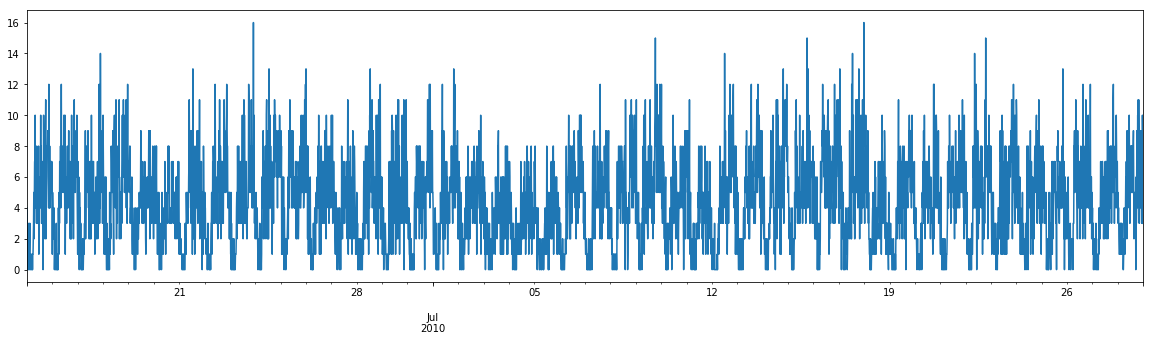

In [3]:
#in March ts looks like this, it strongly suggests daily and weekly cycle
plt.figure(figsize=(20, 5))
ts['2010-6-15':'2010-7-28'].plot()

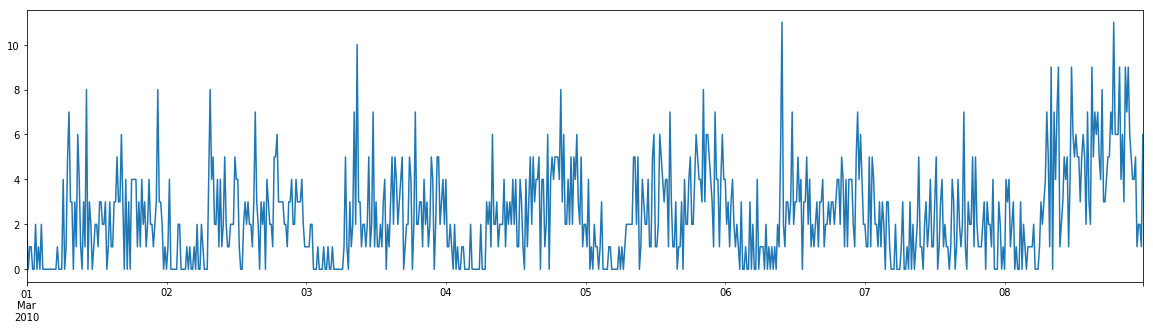

In [4]:
plt.figure(figsize=(20, 5))
ts['2010-03-01':'2010-03-8'].plot()

## Stationary test and smoothing

In [7]:
#test stationary of ts
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(ts)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                   -21.467619
p-value                            0.000000
#Lags Used                        47.000000
Number of Observations Used    22956.000000
Critical Value (1%)               -3.430635
Critical Value (5%)               -2.861666
Critical Value (10%)              -2.566837
dtype: float64


In [8]:
#p value is rather small, ts is stationary

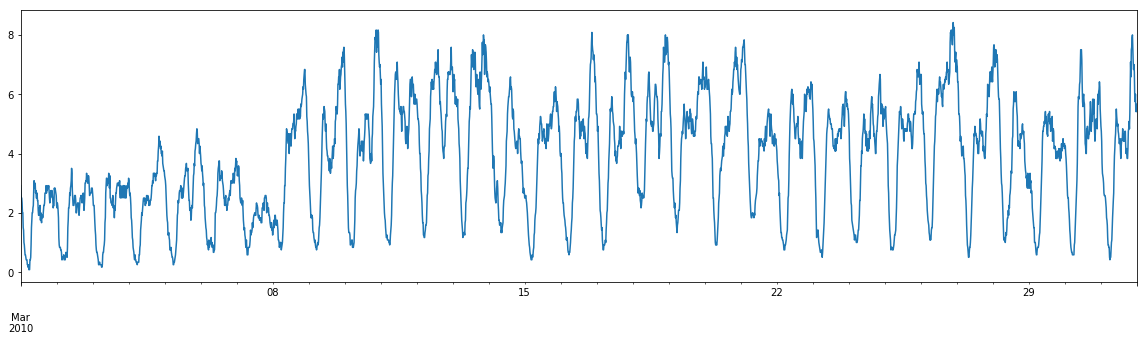

In [9]:
#but ts has too many zigzag, apply a smoothing by rolling mean of 12 hours window, 
#get continuous time series cts
#for example in March cts looks like this
cts=ts.rolling(window=12).mean()
cts.dropna(inplace=True)
cts['2010-03-01':'2010-03-31'].plot(figsize=(20,5))

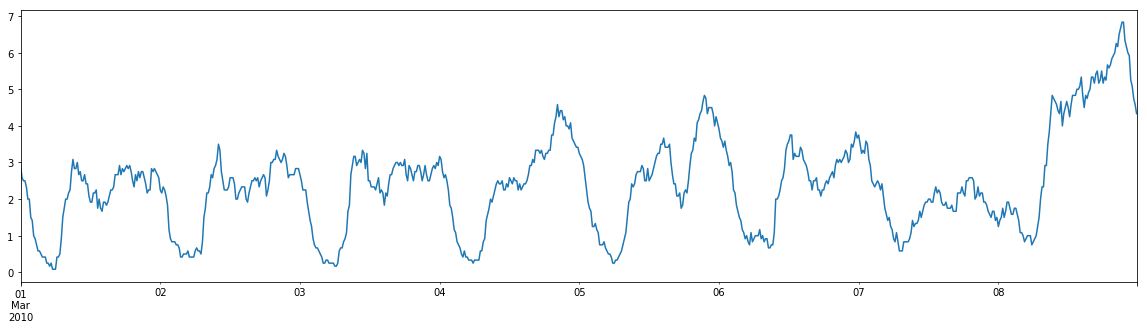

In [10]:
cts['2010-03-01':'2010-03-08'].plot(figsize=(20,5))

## Seasonal-trend decomposition

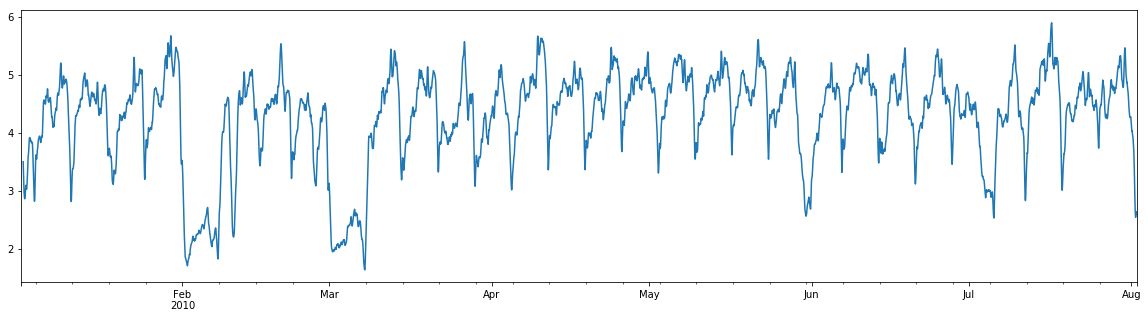

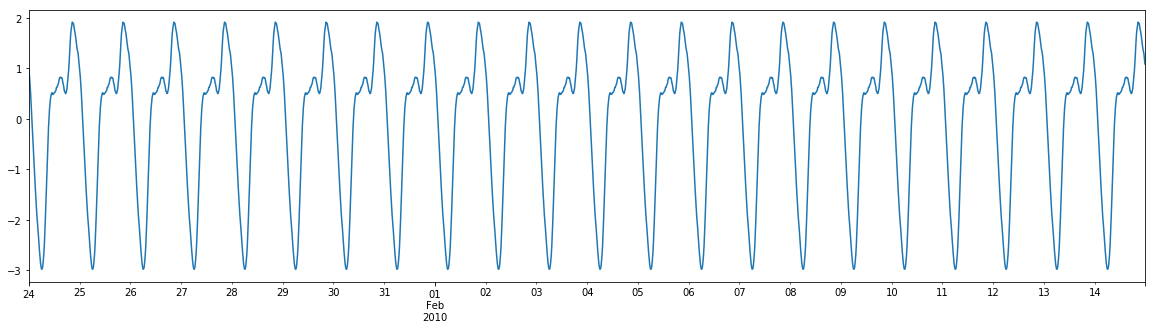

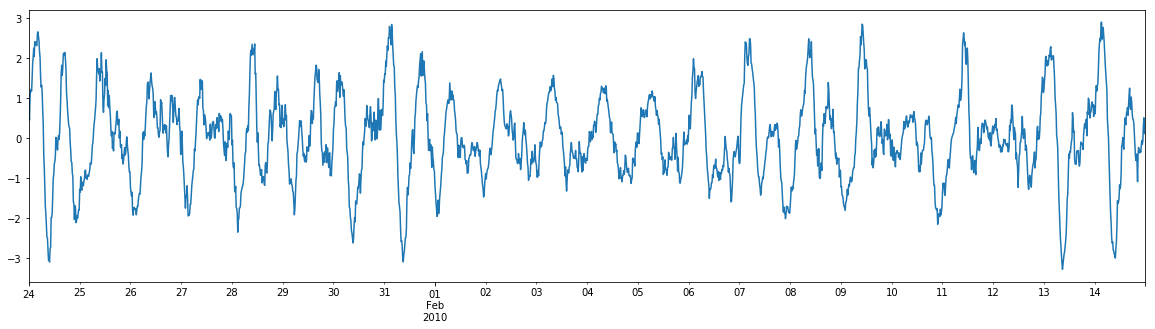

In [11]:
#considering the strong daily cycle, we decompose cts into trend + seasonal,
#in fact it has some weekly seasonality which we first neglect here
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(cts,freq=96)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

#trend in the whole 8 months
plt.figure(figsize=(20, 5))
trend['2010-1-1':'2010-8-1'].plot()
#daily seasonality 
plt.figure(figsize=(20, 5))
seasonal['2010-1-24':'2010-2-14'].plot()
plt.figure(figsize=(20, 5))
residual['2010-1-24':'2010-2-14'].plot()

## Seasonal ARMA model 

In [17]:
import statsmodels.api as sm
mod = sm.tsa.SARIMAX(cts)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                22993
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4050.317
Date:                Sun, 06 Oct 2019   AIC                           8104.634
Time:                        18:01:29   BIC                           8120.720
Sample:                    01-01-2010   HQIC                          8109.861
                         - 08-28-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.000   2571.632      0.000       0.997       0.999
sigma2         0.0833      0.001    113.574      0.000       0.082       0.085
Ljung-Box (Q):                    23881.06   Jarque-

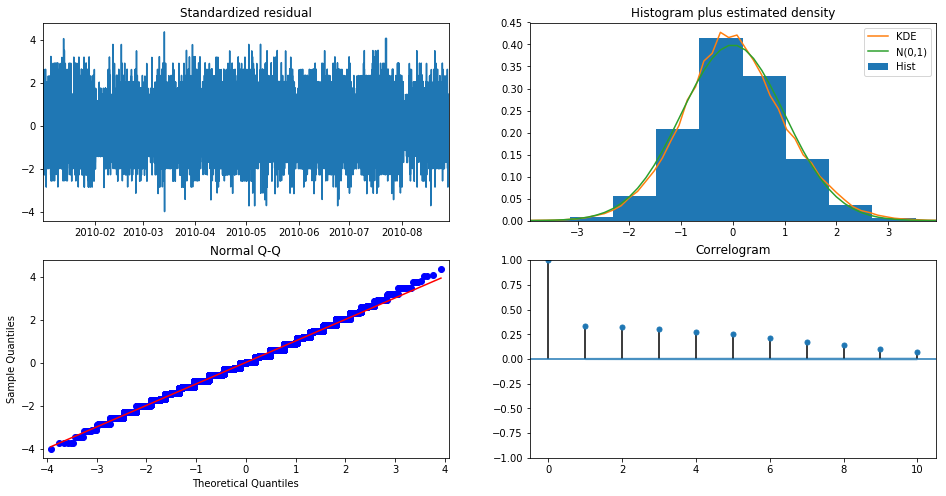

In [18]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

/Users/beingcshen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


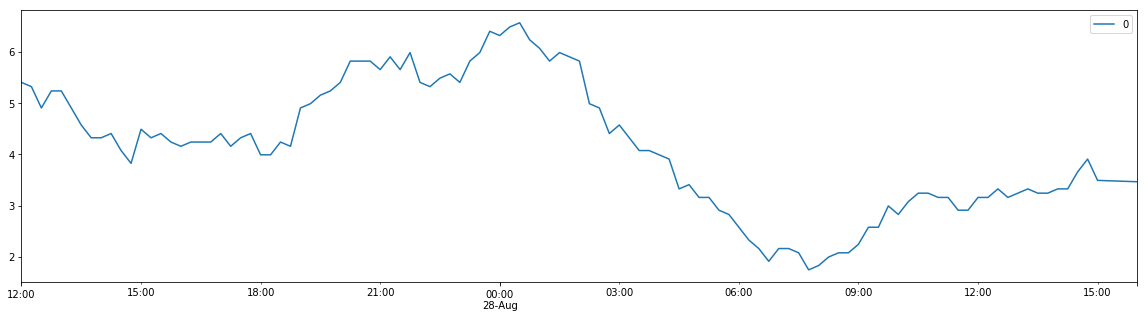

In [19]:
p = res.predict(start='2010-08-27 12:00:00', end='2010-08-28 16:00:00')
predictions=pd.DataFrame(p)
predictions.plot(figsize=(20, 5),subplots=False,layout=[5,5])

Prediction for 1 hour in the future

In [25]:
predictions.tail()

,0
2010-08-28 15:00:00,3.493230
2010-08-28 15:15:00,3.486473
2010-08-28 15:30:00,3.479729
2010-08-28 15:45:00,3.472999
2010-08-28 16:00:00,3.466281


# LSTM model

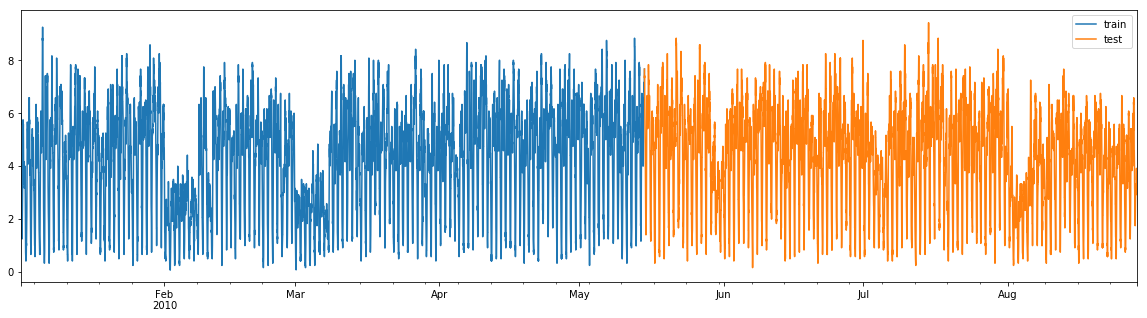

In [26]:
#train test split 
split_date = pd.Timestamp('2010-5-15')

train = cts.loc[:split_date]
test = cts.loc[split_date:]

ax = train.plot()
test.plot(ax=ax,figsize=(20,5))
plt.legend(['train', 'test'])

In [40]:
#construct correct data format for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [41]:
look_back = 96  #because a daily cycle contains 96 15minutes
import numpy as np
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [43]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [44]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

In [52]:
#train model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=70)

Epoch 1/20
12757/12757 [==============================] - 1s 66us/step - loss: 0.0830
Epoch 2/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0638: 0s - loss:
Epoch 3/20
12757/12757 [==============================] - 0s 33us/step - loss: 0.0663
Epoch 4/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0657
Epoch 5/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0649
Epoch 6/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0640: 0s - loss: 
Epoch 7/20
12757/12757 [==============================] - 1s 43us/step - loss: 0.0630
Epoch 8/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0630
Epoch 9/20
12757/12757 [==============================] - 0s 35us/step - loss: 0.0660
Epoch 10/20
12757/12757 [==============================] - 0s 33us/step - loss: 0.0647
Epoch 11/20
12757/12757 [==============================] - 0s 32us/step - loss: 0.0622
Epoch 12/20
12757/12757 [==

In [53]:
# predict on test set
prediction = model.predict(testX)

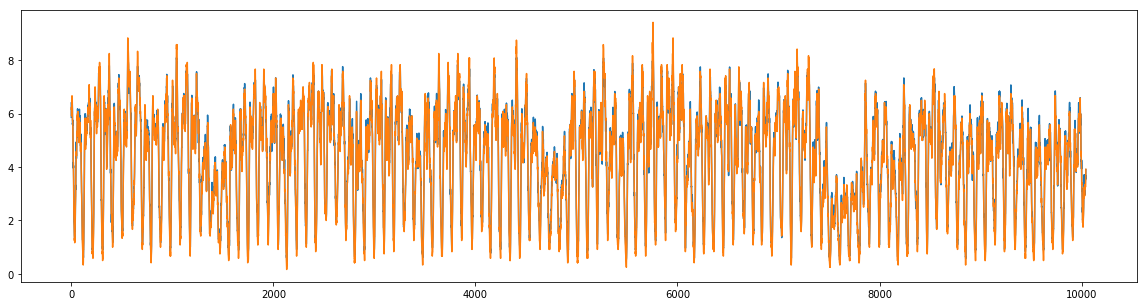

In [54]:
plt.figure(figsize=(20,5))
plt.plot(prediction[::])
plt.plot(testY[::])

In [55]:
trainPredict= model.predict(trainX)
# calculate root mean squared error of the prediction on the test set
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.25 RMSE
Test Score: 0.25 RMSE


In [56]:
#train LSTM using total time series 
ctsX, ctsY= create_dataset(cts,96)
ctsX= np.reshape(ctsX, (ctsX.shape[0],1, ctsX.shape[1]))
model.fit(ctsX, ctsY,epochs=10, batch_size=70, verbose=2)
prediction=model.predict(ctsX)

Epoch 1/10
 - 1s - loss: 0.0602
Epoch 2/10
 - 1s - loss: 0.0572
Epoch 3/10
 - 1s - loss: 0.0560
Epoch 4/10
 - 1s - loss: 0.0556
Epoch 5/10
 - 1s - loss: 0.0577
Epoch 6/10
 - 1s - loss: 0.0568
Epoch 7/10
 - 1s - loss: 0.0586
Epoch 8/10
 - 1s - loss: 0.0538
Epoch 9/10
 - 1s - loss: 0.0559
Epoch 10/10
 - 1s - loss: 0.0525


In [69]:
future= pd.date_range('2010-08-28 15:00:00', periods=4, freq='15T')
futurets = pd.Series(3.5, index=future)
cfts=cts.append(futurets) 

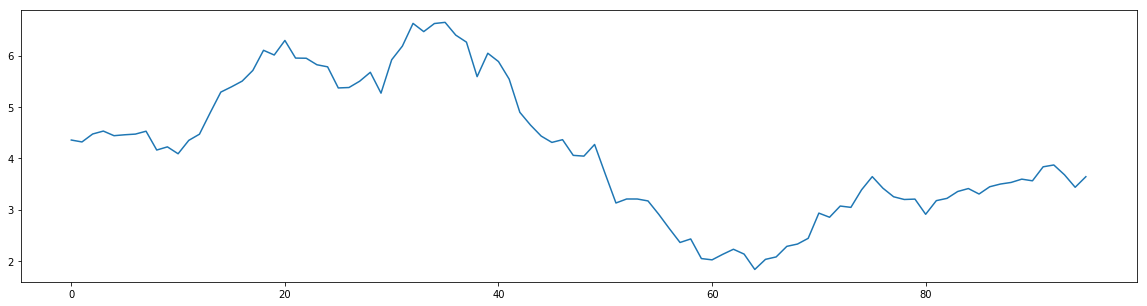

In [70]:
cftsX, cftsY=create_dataset(cfts,96)
cftsX=np.reshape(cftsX,(cftsX.shape[0],1,cftsX.shape[1]))
cfpredict=model.predict(cftsX)
plt.figure(figsize=(20,5))
plt.plot(cfpredict[-96:])

Prediction of demand in the next hour

In [72]:
cfpredict[-4:]

array([[3.871859 ],
       [3.6805716],
       [3.4374094],
       [3.6434107]], dtype=float32)